<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

## Usage
This is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables -SLET
* List of SSP's -SLET
* List of time horizons - SLET

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind](#wind)

### [Land's climate variables](#land_climate_variables)
* [Landslides](#landslides)

### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* [Relative sea level rise](#relative_sea_level_rise)
* [Water availability](#water_availability)
* floods (fluvial)
* floods (coastal)
### [Second effects of climate variables](#second_effect_climate_variables)
* [cyclone risk](#cyclone_risk)
* [earthquakes (not climate related])
* [Tsunamis]

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com


<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [7]:
#User inputs
import os.path

#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/pemba_loc.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
cwd=os.getcwd()
out_path= os.path.join(cwd,'outputs')

bCRS='EPSG:4326' #projection CRS (default = 'EPSG:4326')

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:32737' #metric CRS for buffer in meters 


## Import python packages

In [8]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D
import seaborn as sns

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name 
from FunctionsAndClass import year_copernicus
from FunctionsAndClass import Display_map_projects

<a id='load_shapefile'></a>
## Load shapefiles and plot

,Name
0,PT1_Pemba - Breidge Paquite
1,PT11_Pemba flooding area
2,PT6_Erosion area Rua dos Camponeses


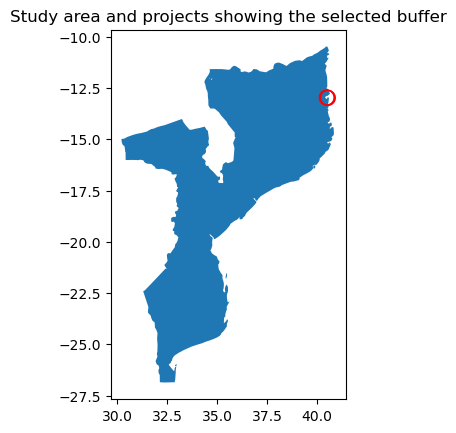

In [9]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#Calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS) #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer)#assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS) #project back to orginal crs

    
#plot shapefiles
fig, ax = plt.subplots()
study_area.plot(ax=ax,)
#projects.plot(ax=ax,color='Black')
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
ax.set_title('Study area and projects showing the selected buffer')

#show table
projects[[project_id]]


In [4]:
### DELETE THIS CELL? 
# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = name_project.str.replace('(','') # take off every ( of project names
name_project = name_project.str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus
first_year=1950
last_year =2100

### YEAR
year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index or dates vector

In [10]:
#### DELETE THIS CELL ALSO? 

# name project in mozambique, those ones were added in the shp (there were initially not in the shapefile)
name_projects = np.array(['WTP_Mutua_EIB', 'Gorongosa_EIB', 'Chimoio_WTP_EIB', 'Pemba_EIB'])

lon_projects_data = np.array([34.5927839939706, 34.07824286310398 , 33.47333313659342, 40.52545156033736]) # decimal degrees
lon_projects = pd.Series(lon_projects_data)

lat_projects_data = np.array([-19.495079648575242, -18.68063728746643, -19.125095255188334,-12.973942656747809]) # decimal degrees
lat_projects = pd.Series(lat_projects_data) 
buffer_area_project=2
area_projects = [lat_projects - buffer_area_project, lat_projects+buffer_area_project, lon_projects-buffer_area_project,lon_projects+buffer_area_project] # list format

# elevation above sea level 
elevation_asl_data = np.array([15, 383, 723, 47]) # unit m 
elevation_asl = pd.Series(elevation_asl_data) # unit m 

# add informations of projects in one dataframe
infos_projects = pd.DataFrame()
infos_projects['Name project'] = name_projects
infos_projects['Longitude DD'] = lon_projects
infos_projects['Latitude DD'] = lat_projects
infos_projects['Elevation above sea level m'] = elevation_asl
infos_projects

,Name project,Longitude DD,Latitude DD,Elevation above sea level m
0,WTP_Mutua_EIB,34.592784,-19.495080,15
1,Gorongosa_EIB,34.078243,-18.680637,383
2,Chimoio_WTP_EIB,33.473333,-19.125095,723
3,Pemba_EIB,40.525452,-12.973943,47


<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
Data source: https://climateknowledgeportal.worldbank.org/download-data

### Precipitation 

#### Incremental rainfall change 
* yearly average precipitation: pe annual mean
* seasonal average precipitation: pr seasonal mean

#### Extreme rainfall change  
* Average of the largest daily precipitation amount: "rx1day" 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* return period of current 50 and 100 year event 

### Temperature
#### Incremental air temperature change
* Yearly mean temperature (average): tas

#### Extreme temperature increase 
* Annual number of hot days >40 degrees C (average): hd40
* Number of hot days >35 degrees C (average): hd35 
* Maximum of daily max-temperature (per year): txx 
* Average of maximum temperature: tasmax 

## Variables 
* Anomaly or climatology; anomaly is based on reference period 1995-2914
* periods: 2020-2039 and 2040-3059 
* ssps: ssp1.19, ssp1.26, ssp2.45, ssp3.70, ssp5.85
* gcms: median, p10, or p90 pecentile of ensemble models


In [11]:
#Read downloaded precipitation and temperature data
#Choolse variables
periods_future=['2020-2039','2040-2059'] #['2020-2039','2040-2059']
periods_frp=['2010-2039','2035-2064'] #['2010-2039','2035-2064']
ssps=['ssp119','ssp126','ssp245','ssp370','ssp585'] #['ssp119','ssp126','ssp245','ssp370','ssp585']
gcms=['median','p10','p90'] #['median','p10','p90']

variables= {
    #Temperature
        #era/cru
          #  'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
           # 'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
          #  'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
          #  'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
           # 'climatology-tasmax-annual-mean_cru':{'perio
          #  'climatology-hd40':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'anomaly-hd40':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'anomaly-hd35':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'anomaly-tasmax':{'periods':periods_future,'ssps':ssps,'gcms':gcms}, 
          #  'anomaly-txx':{'periods':periods_future,'ssps':ssps,'gcms':gcms}, #txx=maximum of daily max temperature
           # 'climatology-txx':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            #'anomaly-tas':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'climatology-tas':{'periods':periods_future,'ssps':ssps,'gcms':gcms}, #data not downloaded 
    #Precipitation
       #era/cru
         #   'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
         #   'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
         #   'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
         #   'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
          #  'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
          #  'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
          # 'frp100yr-rx1day-period-mean_cmip6_period':{'periods':periods_frp,'ssps':ssps,'gcms':gcms}, 
          #  'frp50yr-rx1day-period-mean_cmip6_period':{'periods':periods_frp,'ssps':ssps,'gcms':gcms},
         #   'climatology-rx5day-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
         #   'climatology-rx1day-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
         #   'climatology-pr-monthly-mean_cmip6_monthly':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'climatology-pr-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
     # 'anomaly-pr-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
           # 'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':periods_future,'ssps':ssps,'gcms':gcms}
            }
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,'past',None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,'past',:],:]=stats.T.values
            else:
                #print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            #print(data_path,"not found")
                            projects[varname]='not found'

cckp_output.to_csv('outputs/csv/cckp_output.csv')

projects[[project_id,varname]].head() 
#cckp_output

,Name,anomaly-pr-monthly-mean_cmip6_monthly_2040-2059_ssp585_p90
0,PT1_Pemba - Breidge Paquite,not found
1,PT11_Pemba flooding area,not found
2,PT6_Erosion area Rua dos Camponeses,not found


In [12]:

#Plooting chosen dataset
var='anomaly-hd40'
ssp='ssp245'
period='2020-2039'
gcm='median'

dataset=get_cckp_file_name(var,ssp,period,gcm)
print(dataset)

plot_data=read_cckp_ncdata(dataset)

data=rioxarray.open_rasterio(plot_data)#
data.close() # until here it can run multiple times 
# and with the tempfile2 name it stille refers to tempfile access denied - so it is a general name? 

varname='_'.join((var,period,ssp,gcm))
#projects[varname].head() 

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/anomaly-hd40-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_median_2020-2039.nc


In [13]:
# fig, ax = plt.subplots()
data_clip = data.rio.clip(study_area.geometry, study_area.crs, drop=True)
nodata = rasterio.open(data_clip).nodata

data_clip.close()
#data_clip=data # Shows sorunding temperatures - not cliped to the study_area
xlim = ([study_area.total_bounds[0]-0.5,  study_area.total_bounds[2]+0.5])
ylim = ([study_area.total_bounds[1]-0.5,  study_area.total_bounds[3]+0.5])

#earthquakes_clip=earthquakes_clip.where(earthquakes_clip != nodata)
data_clip=data_clip.where(data_clip != 1e+20)
data_clip.plot(ax=ax,cmap='Blues', xlim=(xlim),ylim=(ylim))
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 

study_area.plot(ax=ax, edgecolor="black", facecolor="none")
title='Chosen climate scenario: \n'+var+'_ '+ssp+'_ '+period+'_ '+gcm
ax.set_title(title)

data_clip.close()


TypeError: invalid path or file: <xarray.DataArray (band: 1, y: 15, x: 10)>
array([[[1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 0.00e+00],
        [1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20, 0.00e+00, 0.00e+00,
         0.00e+00, 5.00e-02, 0.00e+00, 0.00e+00],
        [1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20, 0.00e+00,
         1.00e-01, 1.50e-01, 5.00e-02, 0.00e+00],
        [2.55e+00, 2.85e+00, 3.70e+00, 0.00e+00, 1.00e+20, 3.00e-01,
         1.00e-01, 1.00e-01, 5.00e-02, 0.00e+00],
        [8.50e+00, 7.75e+00, 1.03e+01, 6.25e+00, 1.00e+20, 3.50e-01,
         8.00e-01, 6.00e-01, 1.00e-01, 0.00e+00],
        [1.00e+20, 1.00e+20, 4.45e+00, 7.75e+00, 6.85e+00, 4.45e+00,
         3.40e+00, 1.50e-01, 0.00e+00, 1.00e+20],
        [1.00e+20, 1.00e+20, 2.00e-01, 4.20e+00, 6.10e+00, 3.30e+00,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 1.00e+20, 5.00e-01, 4.70e+00, 1.85e+00, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 1.00e+20, 9.00e-01, 3.70e+00, 1.00e+20, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 1.00e+20, 3.35e+00, 2.65e+00, 5.00e-02, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 8.15e+00, 4.90e+00, 1.95e+00, 0.00e+00, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 5.55e+00, 5.60e+00, 2.10e+00, 0.00e+00, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 4.95e+00, 5.75e+00, 1.10e+00, 0.00e+00, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20],
        [1.00e+20, 1.00e+20, 2.25e+00, 0.00e+00, 1.00e+20, 1.00e+20,
         1.00e+20, 1.00e+20, 1.00e+20, 1.00e+20]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0
  * y            (y) float64 -11.0 -12.0 -13.0 -14.0 ... -22.0 -23.0 -24.0 -25.0
    spatial_ref  int32 0
Attributes: (12/35)
    activity_id:           ScenarioMIP
    AREA_OR_POINT:         Area
    climate_data_id:       CMIP6
    cmip6-ng:              Some daily data has been acquired through the CMIP...
    cmor_version:          3.4.0
    Conventions:           CF-1.7 CMIP-6.2
    ...                    ...
    realm:                 atmos
    table_id:              day
    scale_factor:          1.0
    add_offset:            0.0
    long_name:             anomaly-hd40-annual-mean
    _FillValue:            1e+20

In [8]:
#Overwiev table of worldbank precipitation and temperature data
cckp_output=cckp_output.astype(float).round(2)
cckp_output.reset_index().groupby(['variable', 'period','ssp']).agg(lambda x: ' \ '.join([str((k)) for k in x])).T

variable                            anomaly-pr-monthly-mean_cmip6_monthly  \
period                                                          2020-2039   
ssp                                                                ssp119   
Name                                                                        
gcm                                                    median \ p10 \ p90   
PT1_Pemba - Breidge Paquite                               nan \ nan \ nan   
PT11_Pemba flooding area                                  nan \ nan \ nan   
PT6_Erosion area Rua dos Camponeses                       nan \ nan \ nan   

variable                                                                     \
period                                                                        
ssp                                              ssp126              ssp245   
Name                                                                          
gcm                                  median \ p10 \ p90  median \ p10 \ p90   
PT1_Pemba - Breidge Paquite             nan \ nan \ nan     nan \ nan \ nan   
PT11_Pemba flooding area                nan \ nan \ nan     nan \ nan \ nan   
PT6_Erosion area Rua dos Camponeses     nan \ nan \ nan     nan \ nan \ nan   

variable                                                                     \
period                                                                        
ssp                                              ssp370              ssp585   
Name                                                                          
gcm                                  median \ p10 \ p90  median \ p10 \ p90   
PT1_Pemba - Breidge Paquite             nan \ nan \ nan     nan \ nan \ nan   
PT11_Pemba flooding area                nan \ nan \ nan     nan \ nan \ nan   
PT6_Erosion area Rua dos Camponeses     nan \ nan \ nan     nan \ nan \ nan   

variable                                                                     \
period                                        2040-2059                       
ssp                                              ssp119              ssp126   
Name                                                                          
gcm                                  median \ p10 \ p90  median \ p10 \ p90   
PT1_Pemba - Breidge Paquite             nan \ nan \ nan     nan \ nan \ nan   
PT11_Pemba flooding area                nan \ nan \ nan     nan \ nan \ nan   
PT6_Erosion area Rua dos Camponeses     nan \ nan \ nan     nan \ nan \ nan   

variable                                                                     \
period                                                                        
ssp                                              ssp245              ssp370   
Name                                                                          
gcm                                  median \ p10 \ p90  median \ p10 \ p90   
PT1_Pemba - Breidge Paquite           -9.26 \ nan \ nan     nan \ nan \ nan   
PT11_Pemba flooding area              -9.26 \ nan \ nan     nan \ nan \ nan   
PT6_Erosion area Rua dos Camponeses   -9.26 \ nan \ nan     nan \ nan \ nan   

variable                                                 \
period                                                    
ssp                                              ssp585   
Name                                                      
gcm                                  median \ p10 \ p90   
PT1_Pemba - Breidge Paquite             nan \ nan \ nan   
PT11_Pemba flooding area                nan \ nan \ nan   
PT6_Erosion area Rua dos Camponeses     nan \ nan \ nan   

variable                            changefactorfaep100yr-rx1day-period-mean_cmip6_period  \
period                                                                          2020-2039   
ssp                                                                                ssp119   
Name                                                                                        
gcm   

<a id='wind'></a>
## Wind Speed

Daily wind speed, historical and projected.

Data source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

In [10]:
### Extraction of Near-surface wind speed data
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'

### Earthquakes - Land
source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en&theme=color_light

GAR atlas: fully probabilistic seismic hazard analysis at global level was developed by CIMNE and INGENIAR Ltda. This hazard model is a continuation and improvement of the one developed in the framework of GAR13 where a set of tectonic provinces were identified and characterized by means of a set of parameters that describe the future seismic activity on each of them based on historical records together with relationships to obtained hazard intensities as a function of magnitude and distance. The hazard analysis was performed using the program CRISIS2014, a state-of-the-art tool for these kinds of tasks and widely known and acknowledged by experts in the field across the world. The chosen hazard intensity measure for this case was spectral acceleration and to guarantee a good connection between the hazard and the exposure characteristics, results for several ordinates between 0.0 and 2.3 seconds were computed. More detail about the probabilistic seismic hazard analysis can be found in Cardona et al. (2015).

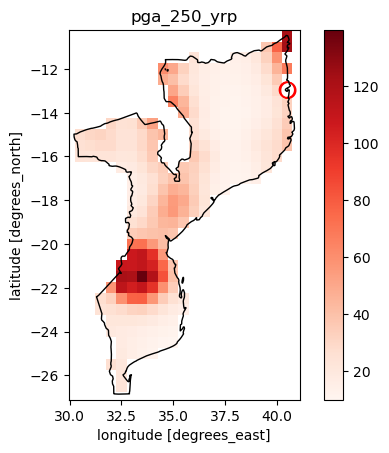

In [56]:


projects_comb = gpd.read_file(project_location_path).to_crs(bCRS) #overview apart from wb data

earthquakes_path=os.path.join(data_folder,'Earthquakes/pga_250_yrp.tif') 

#spatial stats
projects_comb['earthquakes_pga_250_yrp']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=earthquakes_path, 
                                                            all_touched=True, stats='max'))
#show table
projects_comb[[project_id,'earthquakes_pga_250_yrp']].head()

xlim = ([study_area.total_bounds[0]-0.25,  study_area.total_bounds[2]+0.25])
ylim = ([study_area.total_bounds[1]-0.25,  study_area.total_bounds[3]+0.25])

#plot landslides TH
fig, ax = plt.subplots()
earthquakes = rioxarray.open_rasterio(earthquakes_path) 
nodata = rasterio.open(earthquakes_path).nodata

earthquakes_clip = earthquakes.rio.clip(study_area.geometry, study_area.crs, drop=True)
earthquakes_clip=earthquakes_clip.where(earthquakes_clip != nodata) # if to remove nan-values

earthquakes_clip.plot(ax=ax,  cmap='Reds',cbar_kwargs={'label':''},xlim=(xlim),ylim=(ylim))
points=projects_buf.plot(ax=ax,edgecolor='red',facecolor='none') 
study_area.plot(ax=ax,edgecolor="black", facecolor="none")
ax.set_title('pga_250_yrp')

#close
earthquakes_clip.close()



### Tsunami 

This dataset includes an estimation of the annual physical exposure to tsunamis. It is based on three sources: 1) a comprehensive list of reports and scientific papers compiled and utilized in producing tsunami hazard maps as well as finding return periods of future events; 2) applying numerical tsunami models and zooming on selected areas; and 3) a population grid for the year 2010 (provided by LandScanTM Global Population Database, Oak Ridge National Laboratory, Oak Ridge, USA). The unit of reference is the expected average annual population (2010 as the year of reference) exposed (inhabitants).

This product was designed by the International Centre for Geohazards (NGI) for the Global Assessment Report on Risk Reduction (GAR). The dataset was was modelled using global data.

In [1]:
projects_comb = gpd.read_file(project_location_path).to_crs(bCRS) #overview apart from wb data

tsunami_path=os.path.join(data_folder,'Tsunami/ts_physexp.tif') ## 

#spatial stats
projects_comb['tsunami_physical_exposure']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=tsunami_path, 
                                                            all_touched=True, stats='max'))
#show table
projects_comb[[project_id,'tsunami_physical_exposure']].head()

#xlim = ([study_area.total_bounds[0]-0.25,  study_area.total_bounds[2]+0.25])
#ylim = ([study_area.total_bounds[1]-0.25,  study_area.total_bounds[3]+0.25])

#plot landslides TH
fig, ax = plt.subplots()
tsunamis = rioxarray.open_rasterio(tsunami_path) 
nodata = rasterio.open(tsunami_path).nodata
print(nodata)
tsunami_clip = tsunamis.rio.clip(sea_area.geometry, sea_area.crs, drop=True)
tsunami_clip=tsunami_clip.where(tsunami_clip != 255) # if to remove nan-values

tsunami_clip.plot(ax=ax,  cmap='Reds',cbar_kwargs={'label':''},xlim=(xlim),ylim=(ylim))
points=projects_buf.plot(ax=ax,edgecolor='red',facecolor='none') 
sea_area.plot(ax=ax,edgecolor="black", facecolor="none")

ax.set_title('tsunami: physical exposure')

#close
tsunami_clip.close()

NameError: name 'gpd' is not defined

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [31]:

#Read data: 
#Landslides data paths
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf/LS_RF_Mean_1980-2018.tif') 


#spatial stats
projects_comb['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects_comb['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                          all_touched=True, stats='max'))
#show table
projects_comb[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()



,Name,landslides_THmax,landslidesRF_medianMax
0,PT1_Pemba - Breidge Paquite,2.0,None
1,PT11_Pemba flooding area,2.0,None
2,PT6_Erosion area Rua dos Camponeses,2.0,None


Text(0.5, 1.0, 'yearly freq. of rainfall-triggered \n landslides per sq. km.')

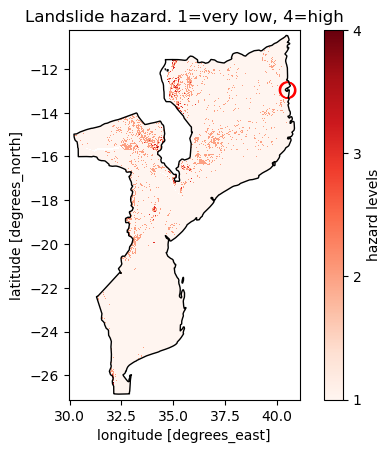

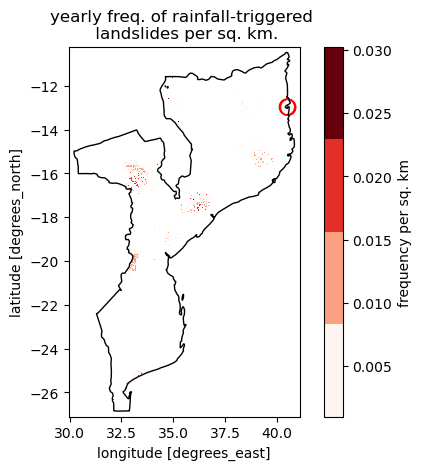

In [76]:
xlim = ([study_area.total_bounds[0]-0.25,  study_area.total_bounds[2]+0.25])
ylim = ([study_area.total_bounds[1]-0.25,  study_area.total_bounds[3]+0.25])

#plot landslides TH
fig, ax = plt.subplots()
landslides_th = rioxarray.open_rasterio(landslidesTH_path) 

landslides_thclip = landslides_th.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_thclip=landslides_thclip.where(landslides_thclip != 255)
landslides_thclip.plot(ax=ax, cmap='Reds',cbar_kwargs={'label':'hazard levels','ticks':[1,2,3,4]},xlim=(xlim),ylim=(ylim))
points=projects_buf.plot(ax=ax,edgecolor='red',facecolor='none') 
study_area.plot(ax=ax,edgecolor="black", facecolor="none")
ax.set_title('Landslide hazard. 1=very low, 4=high')
#close
landslides_thclip.close()

#landslides_clip.close()

#plot landslides RF 
fig, ax = plt.subplots()
landslides_rf = rioxarray.open_rasterio(landslidesRF_path) 

landslides_rfclip = landslides_rf.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_rfclip=landslides_rfclip.where(landslides_rfclip != 0)
landslides_rfclip.plot(ax=ax,vmin=landslides_rfclip.min(),vmax=landslides_rfclip.max(), cmap=plt.cm.get_cmap('Reds',4),cbar_kwargs={'label':'frequency per sq. km'},xlim=(xlim),ylim=(ylim))
#points=projects.plot(ax=ax,color='black') 
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
study_area.plot(ax=ax,edgecolor="black", facecolor="none")
ax.set_title('yearly freq. of rainfall-triggered \n landslides per sq. km.')

In [72]:
#Sea_area -- different shapefile, should be read in the beginning 
sea_area_path=os.path.join(data_folder,'Mozambique_PPIS/sea_area.shp')
sea_area = gpd.read_file(sea_area_path).to_crs(bCRS)


<a id='relative_sea_level_rise'></a>
## Relative sea level rise   - try read nc file in python

In [96]:
## use copernicus or NASA data ? NASA data are in COWI servor \\COWI.net\projects\A245000\A248363\CRVA\Datasets\SeaLevelRise\Nasa
# use mean sea level > https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators-cmip6?tab=overview 

#sealevel_path=os.path.join(data_folder,'SeaLevelRise\Nasa\GlobalSeaLevel\AR6_Projections\Global\medium_confidence\ssp245\glaciers_ssp245_medium_confidence_values.nc') 

#sealevel_path=os.path.join(data_folder,'SeaLevelRise\Nasa\GlobalSeaLevel\AR6_Projections\Global\medium_confidence\ssp245

# I HAVE TROUBLE READING THE NC FILES 

#cwd = os.getcwd() 
#print(cwd)  
#sealevel_path=os.path.join(data_folder,'SeaLevelRise/Nasa/RegionalSeaLevel/AR6_Projections/Regional/medium_confidence/ssp585/AIS_ssp585_medium_confidence_values.nc')
#sealevel_file=nc.Dataset(sealevel_path,'r')
edgar=xr.open_dataset(sealevel_path)
edgar = edgar.to_dataframe()
edgar = edgar.reset_index()
#edgar=edgar['lat']
#edgar_filt=edgar.loc[(edgar['quantiles']== 1.0) & (edgar['years'] == 2020)]
#ds=ds['locations']

#print(ds)


#select: 

#T = edgar.rio.set_spatial_dims(x_dim=edgar['lon'], y_dim=edgar['lat'])
#bT.rio.crs

#lat=sealevel_file.variables['lat'][:]
#lon=sealevel_file.variables['lon'][:]
#sl_change=sealevel_file.variables['sea_level_change'][:]
#yr=sealevel_file.variables['years'][:]

#print('fileshape=',sealevel_file['lat'])
#temp=file2read.variables[]
#print(file2read.variables.keys())

#data = temp[:]*1
#file2read.close()
#plt.imshow(sealevel_file['sea_level_change'][1,1,:])
#sealevel_file.plt.imshow(sealevel_file) 

#dataset=sealevel_path
#print(dataset)


#def read_sealevel_nc(dataset):
 #   with rioxarray.open_rasterio(dataset,decode_times=False [3]) as ncdata:
  #      ncdata.rio.write_crs('EPSG:4326', inplace=True)
  #      ncdata.rio.to_raster('sealevelData.tif')
  #      ncdata.close()
        
#plot_data=read_sealevel_nc(dataset)
#print(plot_data)   

#data=rioxarray.open_rasterio(plot_data)#
#data.close()


In [97]:
edgar_filt=edgar.loc[(edgar['quantiles'] == 1.0)&(edgar['years'] == 2020)] #evt. sæt quantiles til float
print(type(edgar_filt))
#edgar_gdf = gpd.GeoDataFrame(edgar_filt, geometry=gpd.points_from_xy(edgar_filt.lon, edgar_filt.lat))


<class 'pandas.core.frame.DataFrame'>


<a id='water_availability'></a>
## Water availability  - why are the values the same for all scenarios?! 
Represented with water stress

Did not find historical data, look into world bank

Source for projections from 2020 to 2050 : https://www.wri.org/data/aqueduct-water-stress-projections-data
Informations about how the shp is designed located here : data_folder, Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615 (excel sheet)

In [147]:
## Projection of water stress
# register path to water stress data

waterStress_path=os.path.join(data_folder,'Water_Availability_WaterStress/aqueduct_projections_20150309_shp/aqueduct_projections_20150309.shp')
water_stress= gpd.read_file(waterStress_path).to_crs(bCRS)  
water_stress = gpd.clip(water_stress, study_area)
ws_geometry = water_stress.geometry
#coastFlood_clip = data.(coast_flood.geometry, study_area.crs, drop=True)

#___________________

#water_stress_path=os.path.join(data_folder,'Water_Availability_WaterStress/aqueduct_projections_20150309_shp/aqueduct_projections_20150309.shp')
# register data in default projection 4326
#water_stress = gpd.read_file(water_stress_path).to_crs(bCRS) # uncertain that projeciton is the default one

# filter columns of dataframe that are not water stress related
elements_to_drop=('sv','ut','bt','l','u','20','c','BasinID','dwnBasinID','Shape_Leng','Shape_Le_1') # if a column contains a str in this list, the column should be drop
# 20 to remove the projections for 2020 (the projections were made in 2015)

for name_column_out in elements_to_drop:
    water_stress=water_stress.drop(water_stress.filter(regex=name_column_out).columns, axis=1)
    
# making name of columns more precise
# information on column names come from 
#\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615
scenarios_ws=['ssp2_rcp45','ssp2_rcp85','ssp3_rcp85']
projections_ws = ['projection_2030 ','projection_2040']
old_name = ['ws', '30','40','24','28','38','tl']
new_name = ['ws','_2030','_2040','ssp2_rcp45','ssp2_rcp85','ssp3_rcp85','']

for o,n in zip(old_name,new_name): # iterate accross the two list at a time
    water_stress.columns = water_stress.columns.str.replace(o, n) # replacing "40" by "projection_2040" in names of columns
        
# water_stress is a panda dataframe, not geopanda.dataframe. Need to convert it again in geopandas.geodataframe.GeoDataFrame. 
# Otherwise, impossible to use sjoin later
water_stress = GeoDataFrame(water_stress, crs=bCRS, geometry=ws_geometry) # convert panda.dataframe in geopandas.geodataframe.GeoDataFrame

# join information from water stress to projects
projects=projects.sjoin(water_stress,how='left',predicate='within', lsuffix="_left") # need to rename name of columns to make it understandable
projects.drop('index_right', axis=1, inplace=True) # drop column containing index from water stress
projects # projects stays a geopandas.geodataframe.GeoDataFrame


#projects_comb['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                           # all_touched=True, stats='max'))


ValueError: 'index__left' and 'index_right' cannot be names in the frames being joined

In [114]:

#Display_map_projects(projects,study_area,'water stress','Map presenting water stress projections for Mozambique projects', 2,3 ,out_path)


# This function aims to display every projects wanted by the user with a map as a background

### Parameters of the function : 
# projects: geopanda.dataframe containing projects information
# study_area: geopanda.dataframe containing study_area information
# str_interest: string of the climate variable of interest to be represented
# title_for_image: title for image composed of subplots
# number_rows: the user should indicate the number of rows for the subplots
# number_cols: the user should indicate the number of cols for the subplots
# out_path: begenning of the path to register the image

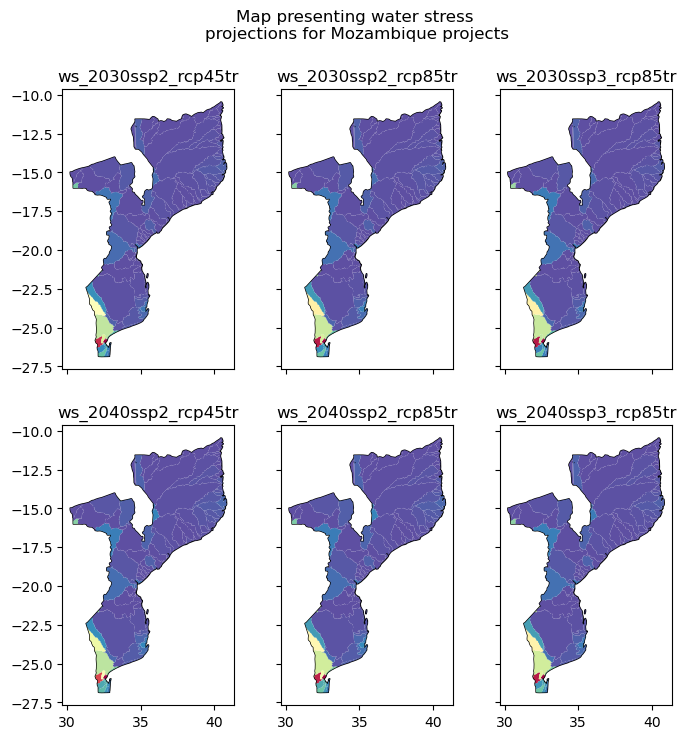

In [142]:
# select climate variable to be represented
columns_to_represent= list(water_stress.filter(regex='ws').columns) # select columns that should be presented in plots
columns_to_represent2=[ ('\n').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from 

# the list column_to_represent and insert \n to do a back to line
number_plots = len(columns_to_represent)

# create figure
fig, ax = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(8,8))

color_dict = {'Low':'green', 'Antarctica':'white', 'Asia':'pink', 
              'Europe':'green', 'North America':'brown',
              'Oceania':'blue', 'Seven seas (open ocean)':'gray','South America':'red'}

#fig, ax = plt.subplots()
#study_area.plot(ax=ax,edgecolor='black',facecolor='none')
#water_stress.plot(ax=ax,column = 'ws2024tl', cmap='Oranges', alpha=1, legend=True, linewidth=0)
#ax.set_title('Current risk ') # set a title to the image

# map in the subplot
columns=water_stress.columns.values
colorbar='Spectral_r'
k = 0

for i in np.arange(3):# columns
    for j in np.arange(2): # lines
        base = study_area.plot(ax=ax[j][i], edgecolor='black',facecolor='none')# background is map of the study area presenting 
        # country borders of this area
        water_stress.plot(ax=ax[j][i], column=columns[k+1], cmap=colorbar)# plot the projects as points; legeng = True 
        # impose a color for the projects point depending on the value in the column      
        # give subplot a title
        ax_created = ax[j][i]
        ax_created.title.set_text(columns_to_represent2[k])       
        k=k+1 # incrementation to iterate columns_to_represent

plt.suptitle('Map presenting water stress \nprojections for Mozambique projects') # give a global name to the imagep
plt.show()


<AxesSubplot: >

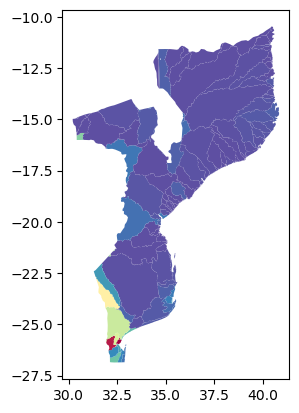

In [146]:
fig, ax=plt.subplots()
water_stress.plot(ax=ax, column=columns[3], cmap=colorbar)

In [49]:
water_stress.columns


Index(['Area_km2', 'ws_2030ssp2_rcp45tr', 'ws_2040ssp2_rcp45tr',
       'ws_2030ssp2_rcp85tr', 'ws_2040ssp2_rcp85tr', 'ws_2030ssp3_rcp85tr',
       'ws_2040ssp3_rcp85tr', 'Shape_Area', 'geometry'],
      dtype='object')

In [65]:
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent=[ (' ').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from the list column_to_represent

In [66]:
columns_to_represent

['projection_2030 ssp2_rcp45__left',
 'projection_2040 ssp2_rcp45__left',
 'projection_2030 ssp2_rcp85__left',
 'projection_2040 ssp2_rcp85__left',
 'projection_2030 ssp3_rcp85__left',
 'projection_2040 ssp3_rcp85__left',
 'projection_2030 ssp2_rcp45_right',
 'projection_2040 ssp2_rcp45_right',
 'projection_2030 ssp2_rcp85_right',
 'projection_2040 ssp2_rcp85_right',
 'projection_2030 ssp3_rcp85_right',
 'projection_2040 ssp3_rcp85_right',
 'projection_2030 ssp2_rcp45',
 'projection_2040 ssp2_rcp45',
 'projection_2030 ssp2_rcp85',
 'projection_2040 ssp2_rcp85',
 'projection_2030 ssp3_rcp85',
 'projection_2040 ssp3_rcp85',
 'projection_2030 ssp2_rcp45cl',
 'projection_2040 ssp2_rcp45cl',
 'projection_2030 ssp2_rcp85cl',
 'projection_2040 ssp2_rcp85cl',
 'projection_2030 ssp3_rcp85cl',
 'projection_2040 ssp3_rcp85cl']

In [67]:
[s.replace('water stress ', '') for s in columns_to_represent]
columns_to_represent

['projection_2030 ssp2_rcp45__left',
 'projection_2040 ssp2_rcp45__left',
 'projection_2030 ssp2_rcp85__left',
 'projection_2040 ssp2_rcp85__left',
 'projection_2030 ssp3_rcp85__left',
 'projection_2040 ssp3_rcp85__left',
 'projection_2030 ssp2_rcp45_right',
 'projection_2040 ssp2_rcp45_right',
 'projection_2030 ssp2_rcp85_right',
 'projection_2040 ssp2_rcp85_right',
 'projection_2030 ssp3_rcp85_right',
 'projection_2040 ssp3_rcp85_right',
 'projection_2030 ssp2_rcp45',
 'projection_2040 ssp2_rcp45',
 'projection_2030 ssp2_rcp85',
 'projection_2040 ssp2_rcp85',
 'projection_2030 ssp3_rcp85',
 'projection_2040 ssp3_rcp85',
 'projection_2030 ssp2_rcp45cl',
 'projection_2040 ssp2_rcp45cl',
 'projection_2030 ssp2_rcp85cl',
 'projection_2040 ssp2_rcp85cl',
 'projection_2030 ssp3_rcp85cl',
 'projection_2040 ssp3_rcp85cl']

In [68]:
# plot results for projects
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
number_plots = len(columns_to_represent)

# trying to do a map with shape of area and points projets
#projects.plot(column='water stress projection_2030 ssp2_rcp45', legend=True)

<AxesSubplot: >

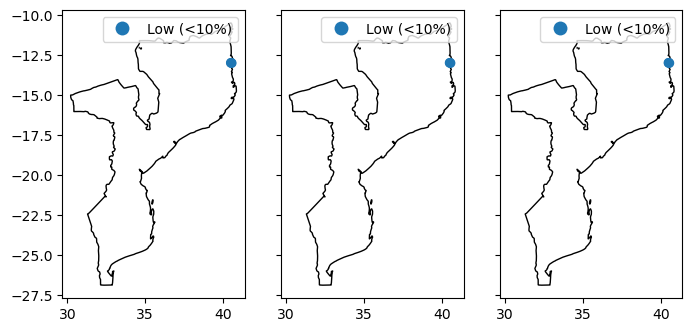

In [69]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(8,8))
#norm = plt.colors.Normalize(vmin=projects.val.min(), vmax=projects.val.max()) # to normalize legend between the different plots
# wait to see if new intallation worked
base = study_area.plot(ax=ax1,color='white', edgecolor='black')
projects.plot(ax=ax1, column='water stress projection_2030 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax2,color='white', edgecolor='black')
projects.plot(ax=ax2, column='water stress projection_2040 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax3,color='white', edgecolor='black')
projects.plot(ax=ax3, column='water stress projection_2030 ssp2_rcp85',legend=True)
#projects.plot(column='water stress projection_2030 ssp2_rcp45',ax=base, legend=True);

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 



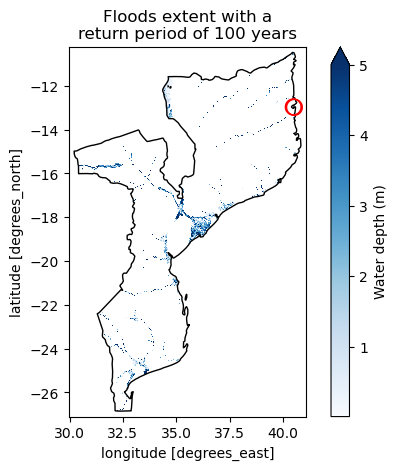

In [64]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()

floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)

nodata = rasterio.open(flood_path).nodata
floods_clip=floods_clip.where(floods_clip != nodata) 


floods_clip.plot(ax=ax,vmax=5,cmap='Blues',cbar_kwargs={'label':'Water depth (m)'},xlim=(xlim),ylim=(ylim))
#projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
study_area.plot(ax=ax,edgecolor='black',facecolor='none')
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()


#### Coastal 
Source: WRI Aqueduct database - see https://github.com/wri/Aqueduct40/blob/master/data_dictionary_water-risk-atlas.md 

In [78]:
coastFlood_path=os.path.join(data_folder,'Floods/aquaduct/Y2019M07D12_Aqueduct30_V01/baseline/annual/shapefil.shp')
coast_flood= gpd.read_file(coastFlood_path).to_crs(bCRS)  

clipped = gpd.clip(coast_flood, study_area)
#coastFlood_clip = data.(coast_flood.geometry, study_area.crs, drop=True)


In [ ]:
colums=coast_flood.columns.values
fig, ax = plt.subplots()
study_area.plot(ax=ax,edgecolor='black',facecolor='none')
clipped.plot(ax=ax,column = 'cfr_cat', cmap='Oranges', alpha=1, legend=True, linewidth=0,cbar_kwargs={'label':'hazard levels','ticks':[1,2,3,4]})
ax.set_title('Current risk ') # set a title to the image


                                   Name  \
0           PT1_Pemba - Breidge Paquite   
1              PT11_Pemba flooding area   
2   PT6_Erosion area Rua dos Camponeses   
3           PT1_Pemba - Breidge Paquite   
4              PT11_Pemba flooding area   
5   PT6_Erosion area Rua dos Camponeses   
6           PT1_Pemba - Breidge Paquite   
7              PT11_Pemba flooding area   
8   PT6_Erosion area Rua dos Camponeses   
9           PT1_Pemba - Breidge Paquite   
10             PT11_Pemba flooding area   
11  PT6_Erosion area Rua dos Camponeses   
12          PT1_Pemba - Breidge Paquite   
13             PT11_Pemba flooding area   
14  PT6_Erosion area Rua dos Camponeses   
15          PT1_Pemba - Breidge Paquite   
16             PT11_Pemba flooding area   
17  PT6_Erosion area Rua dos Camponeses   

                                           descriptio timestamp begin   end  \
0                                          Note: null      None  None  None   
1   Note: Comando milita

<AxesSubplot: >

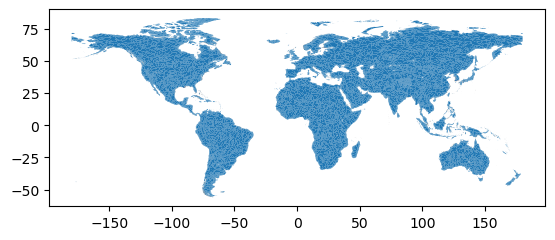

In [158]:
# Get identity
#identify_result = gpd.overlay(projects_buf,coast_flood, how = 'identity')

coast_flood.plot()

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

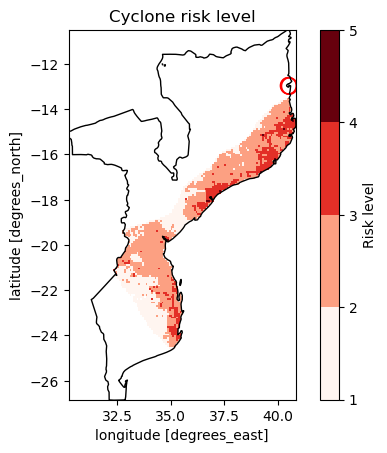

In [68]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
# \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
nodata = rasterio.open(cyclone_path).nodata
cyclone_clip=cyclone_clip.where(cyclone_clip != nodata) 

cyclone_clip.plot(ax=ax,cmap=plt.cm.get_cmap('Reds',4),cbar_kwargs={'label':'Risk level','ticks':[0,1,2,3,4,5]})  #(ax=ax,vmin=0,vmax=20,cmap='Blues',cbar_kwargs={'label':'Water depth (m)'})
#projects.plot(ax=ax) # plot the projects on the map
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
study_area.plot(ax=ax,edgecolor='black',facecolor='none')
#ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image


plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [182]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered


KeyError: "['climatology-hd40_2020-2039_ssp245_median', 'daily-median-Wind-2100-ssp5_8_5'] not in index"

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')